In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
# from backtest import executer
import matplotlib.pyplot as plt
import plotly.express as px
import math
import ast
from scipy.stats import spearmanr, kstest


In [2]:
sns.set(rc={'figure.figsize':(15,8)})

In [3]:
portfolio = pd.read_excel('PORTFOLIO.xlsx')

df = pd.read_csv('sem_var.csv')

df['date'] = pd.to_datetime(df.date)
df['open_date'] = pd.to_datetime(df.open_date)
df['days_open'] = df['days_open'].astype(float)
df['stock1'] = [pair.split("'")[1] for pair in df.pair]

In [4]:
df = df.merge(portfolio.drop_duplicates('ticker'), left_on='stock1', right_on='ticker',how='left')

df.drop(columns=['stock1', 'ticker'], inplace=True)
df['pair'] = df.pair.apply(ast.literal_eval)
df['sorted_pair'] = df.pair.apply(sorted).apply(tuple)

In [5]:
df.drop_duplicates(subset=['date', 'sorted_pair'], keep='first',inplace=True)

In [6]:
df.loc[df['residual_open'] < df['std_open_residual'], 'side'] = 'lower'
df.loc[df['residual_open'] > df['std_open_residual'], 'side'] = 'upper'

In [7]:
returns_list = []
i=1
closed = df.loc[df.status=='close']

for row in closed.itertuples():

    historico_par = df.loc[(df.pair==row.pair) & (df.date.between(row.open_date,row.date))].copy()
    historico_par.set_index('date', inplace=True)
    historico_par['id'] = i
    
    
#     display(historico_par)
#     Custo entrada: 1,22% + 0,1% = 1,31%
#     Custo saida: 1,22% + 0,25% + 0,1% = 1,57% + Aluguel
    
#     display(historico_par)
    aluguel = (1.0143)**((row.days_open+2)/252) -1
    try:
        if row.side == 'lower':
            
            historico_par['ratio_sem_custos'] = historico_par['price_fst_stock'] / historico_par['price_scnd_stock']
            
            historico_par.at[row.open_date, 'price_fst_stock'] = historico_par.at[row.open_date, 'price_fst_stock']
            
            # Entrada
            historico_par.at[row.open_date, 'price_fst_stock'] = historico_par.loc[row.open_date, 'price_fst_stock'] * (1+0.0071)
            historico_par.at[row.open_date, 'price_scnd_stock'] = historico_par.loc[row.open_date, 'price_scnd_stock'] * (1-0.0071)
            
                    
            # Saída
            historico_par.at[row.date, 'price_fst_stock'] = historico_par.loc[row.date, 'price_fst_stock'] * (1-0.0071)
            historico_par.at[row.date, 'price_scnd_stock'] = historico_par.loc[row.date, 'price_scnd_stock'] * (1+(0.0071+aluguel))

            historico_par['ratio'] = historico_par['price_fst_stock'] / historico_par['price_scnd_stock']
            
        else:
            
            historico_par['ratio_sem_custos'] = historico_par['price_scnd_stock'] / historico_par['price_fst_stock']
            
            historico_par.at[row.open_date, 'price_scnd_stock'] = historico_par.loc[row.open_date, 'price_scnd_stock']
            # Entrada
            historico_par.at[row.open_date, 'price_scnd_stock'] = historico_par.loc[row.open_date, 'price_scnd_stock'] * (1+0.0071)
            historico_par.at[row.open_date, 'price_fst_stock'] = historico_par.loc[row.open_date, 'price_fst_stock'] * (1-0.0071)

            # Saida
            historico_par.at[row.date, 'price_scnd_stock'] = historico_par.loc[row.date, 'price_scnd_stock'] * (1-0.0071)
            historico_par.at[row.date, 'price_fst_stock'] = historico_par.loc[row.date, 'price_fst_stock'] * (1+(0.0071+aluguel))

            historico_par['ratio'] = historico_par['price_scnd_stock'] / historico_par['price_fst_stock']
        
        
        historico_par['open_price_first_stock'] = historico_par.at[row.open_date, 'price_fst_stock']
        historico_par['open_price_scnd_stock'] = historico_par.at[row.open_date, 'price_scnd_stock']
        
        historico_par['return'] = (historico_par.ratio / historico_par.ratio.shift(1)) -1
        historico_par['retorno_acumulado'] = np.cumprod(1+historico_par['return']) -1
        
        historico_par['return_sem_custos'] = (historico_par.ratio_sem_custos / historico_par.ratio_sem_custos.shift(1)) -1
        historico_par['retorno_acumulado_sem_custos'] = (np.cumprod(1+historico_par['return_sem_custos']) -1)
        
        returns_list.append(historico_par)
        
    except Exception as e:
#         print(e)
        pass
    
    i+=1

In [8]:
def result_calculator(row, kind='CN'):
    
    if kind=='CN':
        multiplier = 1
    if kind == 'BN':
        multiplier = row.beta_open
    
    if row['residual_open'] < row['std_open_residual']:
        long_result =(row['price_fst_stock'] / row['open_price_first_stock'])
        short_result = (row['open_price_scnd_stock'] / row['price_scnd_stock'])
        
        short_result = multiplier * short_result
        result = (long_result * short_result) - 1
        
        return result, 'lower'
    
    elif row['residual_open'] > row['std_open_residual']:
        long_result = (row['open_price_first_stock'] / row['price_fst_stock'])
        short_result = (row['price_scnd_stock'] / row['open_price_scnd_stock'])
        
        short_result = multiplier * short_result
        result = (long_result * short_result) - 1

        return result, 'upper'

In [9]:
df_returns = pd.concat(returns_list)
df_returns.reset_index(inplace=True)

In [10]:
log_retorno = np.log(1+df_returns.set_index(['date', 'pair', 'open_date','status'])[['return', 'return_sem_custos']]).fillna(0)
retorno_acumulado =  np.exp(log_retorno.cumsum()) - 1
retorno_acumulado.reset_index(inplace=True)

In [11]:
df_returns.halflife.mean()

7.640625

In [12]:
closed = df_returns.loc[df_returns.status=='close']

In [13]:
ibov = pd.read_csv('ibov.csv', usecols=[0,4], index_col=0)
ibov.index = pd.to_datetime(ibov.index)
ibov = ibov.loc[df_returns.date.min():df_returns.date.max()]

In [14]:
log_ret_ibov = np.log(ibov/ibov.shift())
ibov_return = ibov/ibov.shift() -1
ibov_retornos = ibov/ibov.shift() -1
cumsum_ibov = np.cumsum(log_ret_ibov)
ibov_pct = np.exp(cumsum_ibov) -1

In [15]:
# Retorno com custos
acumulado_com_custos = np.cumprod(1+df_returns.groupby('date').sum()['return']) -1

In [16]:
# Resultado sem custos por dia
acumulado_sem_custo = np.cumprod(1+df_returns.groupby('date').sum().return_sem_custos) -1


In [17]:
# Operações Fechadas
fechadas = df_returns.loc[df_returns.status=='close']

fechadas['e_lucro_bruto'] = fechadas['retorno_acumulado_sem_custos'] > 0
fechadas['e_lucro_liquido'] = fechadas['retorno_acumulado'] > 0

retorno_diario = df_returns.groupby('date').sum()

<ipython-input-17-902cf3657bf9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fechadas['e_lucro_bruto'] = fechadas['retorno_acumulado_sem_custos'] > 0
<ipython-input-17-902cf3657bf9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fechadas['e_lucro_liquido'] = fechadas['retorno_acumulado'] > 0


# Graficos

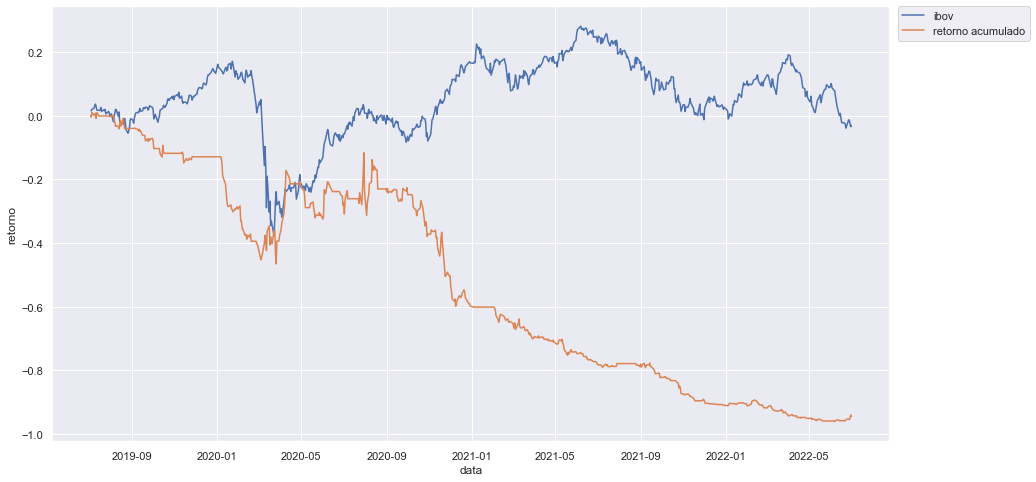

In [18]:
sns.lineplot(x=ibov_pct.index, y=ibov_pct.close, label='ibov')
sns.lineplot(x=acumulado_com_custos.index, y=acumulado_com_custos, label='retorno acumulado')
plt.ylabel('retorno')
plt.xlabel('data')

plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# sns.lineplot(x=cumsum_result_BN.index, y=cumsum_result_BN, label='cointegration beta neutral')


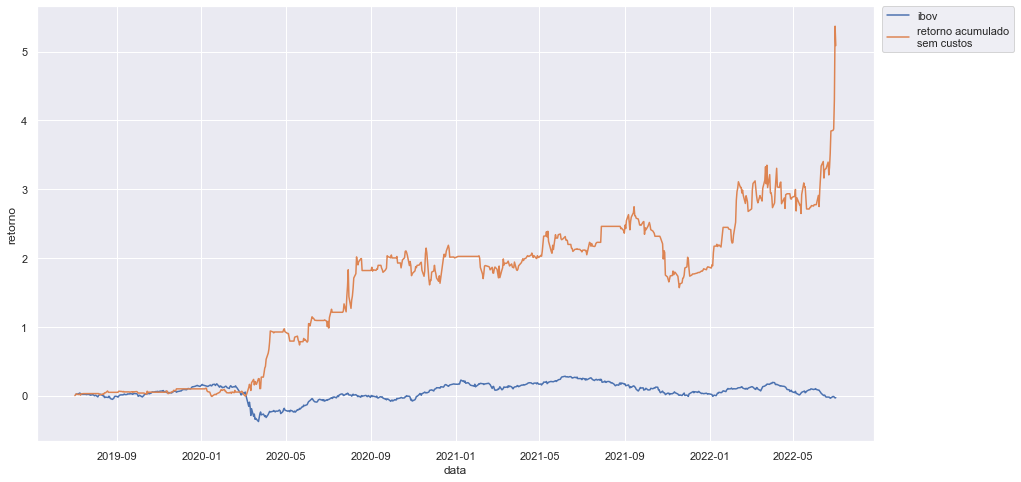

In [19]:
sns.lineplot(x=ibov_pct.index, y=ibov_pct.close, label='ibov')
sns.lineplot(x=acumulado_sem_custo.index, y=acumulado_sem_custo, label='retorno acumulado\nsem custos')
plt.ylabel('retorno')
plt.xlabel('data')

plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [44]:
retornos_diarios = pd.concat([ibov_return, retorno_diario[['return', 'return_sem_custos']]], axis=1)
retornos_diarios.fillna(0, inplace=True)
retornos_diarios.columns = ['ibov', 'retorno_com_custos', 'retorno_sem_custos']

In [45]:
log_retornos = np.log(1+retornos_diarios)
retornos_acumulados = np.exp(log_retornos.cumsum()) -1
retornos_acumulados

,ibov,retorno_com_custos,retorno_sem_custos
2019-07-03,0.000000,0.000000,0.000000
2019-07-04,0.015611,-0.003661,0.010588
2019-07-05,0.020060,0.010990,0.025449
2019-07-08,0.024372,0.001046,0.015362
2019-07-10,0.036984,0.007896,0.022310
...,...,...,...
2022-06-27,-0.012534,-0.952930,3.854673
2022-06-28,-0.014229,-0.954086,3.874462
2022-06-29,-0.023725,-0.950068,4.301092
2022-06-30,-0.034309,-0.940007,5.369185


# Descritivas

In [53]:
retornos_diarios.describe()

,ibov,retorno_com_custos,retorno_sem_custos
count,745.000000,745.000000,745.000000
mean,0.000142,-0.003457,0.002816
std,0.019005,0.028763,0.028099
min,-0.147797,-0.138751,-0.138086
25%,-0.008153,-0.013467,-0.005352
50%,0.000625,0.000000,0.000000
75%,0.009616,0.004115,0.009201
max,0.139082,0.201486,0.201486


In [54]:
coeficiente_liquido, p_valor = spearmanr(retornos_diarios[['ibov', 'retorno_com_custos']])
print('Correlação de Spearman Resutado líquido: {:0.3}'.format(coeficiente_liquido))

Correlação de Spearman Resutado líquido: 0.0129


In [55]:
coeficiente_bruto, p_valor = spearmanr(retornos_diarios[['ibov', 'retorno_sem_custos']])
print('Correlação de Spearman Resutado bruto: {:0.3}'.format(coeficiente_bruto))

Correlação de Spearman Resutado bruto: 0.0275


In [56]:
# TESTE NORMALIDADE
#perform Kolmogorov-Smirnov test
kstest(retornos_diarios.retorno_sem_custos, 'norm')

KstestResult(statistic=0.46349655667498924, pvalue=4.503467688320636e-147)

In [57]:
# TESTE NORMALIDADE
#perform Kolmogorov-Smirnov test
kstest(retornos_diarios.retorno_com_custos, 'norm')

KstestResult(statistic=0.4579846870088634, pvalue=2.0746775529915294e-143)

In [58]:
df_returns['return'].describe()

count    1182.000000
mean       -0.002179
std         0.022271
min        -0.109944
25%        -0.012972
50%        -0.002264
75%         0.007445
max         0.206783
Name: return, dtype: float64

In [59]:
df_returns['return_sem_custos'].describe()

count    1182.000000
mean        0.001775
std         0.021906
min        -0.109944
25%        -0.007965
50%         0.001240
75%         0.010196
max         0.206783
Name: return_sem_custos, dtype: float64

# Eficacia

In [60]:
eficacia = fechadas.set_index('open_date').resample('6M').agg(
    num_operacoes = ('pair', 'count'),
    taxa_acerto = ('e_lucro_bruto', 'mean'),
    tempo_medio_operacao = ('days_open', 'mean')
)

eficacia

,num_operacoes,taxa_acerto,tempo_medio_operacao
open_date,,,
2019-07-31,1,1.000000,7.000000
2020-01-31,15,0.600000,6.533333
2020-07-31,28,0.714286,7.678571
2021-01-31,26,0.653846,7.923077
2021-07-31,25,0.600000,7.640000
2022-01-31,30,0.633333,6.833333
2022-07-31,37,0.540541,7.513514


# Desempenho

In [61]:
vol_ibov = log_ret_ibov.close.std() * math.sqrt(252)
vol_ibov

0.3060079618164384

In [62]:
log_return = np.log(1+retorno_diario['return'])
vol_return = log_return.std() * math.sqrt(252)
vol_return

0.5164685561116649

In [63]:
log_return_sem_custo = np.log(1+retorno_diario['return_sem_custos'])
vol_return_sem_custo = log_return_sem_custo.std() * math.sqrt(252)
vol_return_sem_custo

0.49852523302372037

In [64]:
retorno_acumulado_bruto = retorno_acumulado['return_sem_custos'].iloc[-1]
taxa_acerto = fechadas['e_lucro_bruto'].mean()
retorno_acumulado_liquido = retorno_acumulado['return'].iloc[-1]

desempenho = pd.DataFrame([{
    'retorno_acumulado_bruto':retorno_acumulado_bruto,
    'taxa_acerto': taxa_acerto,
    'retorno_acumulado_liquido': retorno_acumulado_liquido,
    'desvio_padrao': vol_return,
    'sharpe': retorno_acumulado_liquido/vol_return,
    'correlacao_ibov': coeficiente_liquido
    }])

desempenho

,retorno_acumulado_bruto,taxa_acerto,retorno_acumulado_liquido,desvio_padrao,sharpe,correlacao_ibov
0,5.153541,0.623457,-0.943251,0.516469,-1.826347,0.012871


In [66]:
fechadas_halflife = fechadas.loc[(fechadas.days_open > fechadas.halflife) & (fechadas.beta_close!='VAR CLOSE')]
fechadas_stop_var = fechadas.loc[(fechadas.beta_close=='VAR CLOSE')]
fechadas_retorno = fechadas.loc[(abs(fechadas.last_residual) <= fechadas.close_limit) & (fechadas.beta_close!='VAR CLOSE') & (fechadas.days_open <= fechadas.halflife)]

In [67]:
todos_indices = fechadas_stop_var.index.tolist() + fechadas_halflife.index.tolist() + fechadas_retorno.index.tolist()

seen = set()
dupes = [x for x in todos_indices if x in seen or seen.add(x)]    

In [68]:
set(fechadas.index.tolist()) - set(todos_indices)

{1302}

In [70]:
fechadas_var_semestre = fechadas_stop_var.set_index('open_date').resample('6M').agg(
    total_trades = ('status', 'count'),
    gain_halflife = ('e_lucro_bruto', 'mean'),
)
fechadas_var_semestre['loss_halflife'] = 1-fechadas_var_semestre['gain_halflife']

fechadas_var_semestre

,total_trades,gain_halflife,loss_halflife
open_date,,,


In [71]:
halflife_semestre = fechadas_halflife.set_index('open_date').resample('6M').agg(
    total_trades = ('status', 'count'),
    gain_halflife = ('e_lucro_bruto', 'mean'),
)

halflife_semestre['loss_halflife'] = 1-halflife_semestre['gain_halflife']

halflife_semestre

,total_trades,gain_halflife,loss_halflife
open_date,,,
2019-07-31,1,1.000000,0.000000
2020-01-31,12,0.500000,0.500000
2020-07-31,21,0.619048,0.380952
2021-01-31,25,0.640000,0.360000
2021-07-31,21,0.523810,0.476190
2022-01-31,28,0.607143,0.392857
2022-07-31,27,0.407407,0.592593


# Resumo Pares

In [72]:
fechadas_grouped = fechadas.groupby('sorted_pair').agg(
    trades = ('sorted_pair','count'),
    taxa_acerto = ('e_lucro_bruto', 'mean'),
    prazo_medio_operacao = ('days_open', 'mean'),
    retorno_bruto_acum = ('retorno_acumulado_sem_custos', 'sum'),
    retorno_liquidi_acum = ('retorno_acumulado', 'sum')
)

fechadas_grouped.sort_values(by=['trades', 'taxa_acerto'], ascending=False).head(15)

,trades,taxa_acerto,prazo_medio_operacao,retorno_bruto_acum,retorno_liquidi_acum
sorted_pair,,,,,
"(ELET3, ELET6)",17,0.647059,5.294118,0.139527,-0.347181
"(EQTL3, TAEE11)",12,0.583333,5.583333,0.216186,-0.130921
"(CPFE3, EGIE3)",11,0.545455,7.000000,0.136290,-0.180983
"(PETR3, PETR4)",10,0.500000,6.000000,0.059086,-0.226939
"(GGBR4, GOAU4)",8,0.500000,5.625000,0.012063,-0.215605
"(BBDC3, BBDC4)",6,0.833333,6.833333,0.034032,-0.137826
"(BRML3, MULT3)",6,0.833333,6.666667,0.346330,0.165678
"(FLRY3, QUAL3)",6,0.833333,9.166667,0.618380,0.429019
"(GGBR4, USIM5)",6,0.500000,8.666667,0.036608,-0.135913
